## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [3]:
df = pd.read_csv('bikes_rent.csv')

#### Проверка, как выглядит информация:

In [4]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


#### Посмотрим сколько и каких сезонов тут

In [5]:
df.season.value_counts()

3    188
2    184
1    181
4    178
Name: season, dtype: int64

#### Посмотрим типы данных

In [6]:
df.dtypes

season              int64
yr                  int64
mnth                int64
holiday             int64
weekday             int64
workingday          int64
weathersit          int64
temp              float64
atemp             float64
hum               float64
windspeed(mph)    float64
windspeed(ms)     float64
cnt                 int64
dtype: object

#### Посмотрим размер таблицы

In [4]:
df.shape

(731, 13)

Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

/Users/macdrive/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


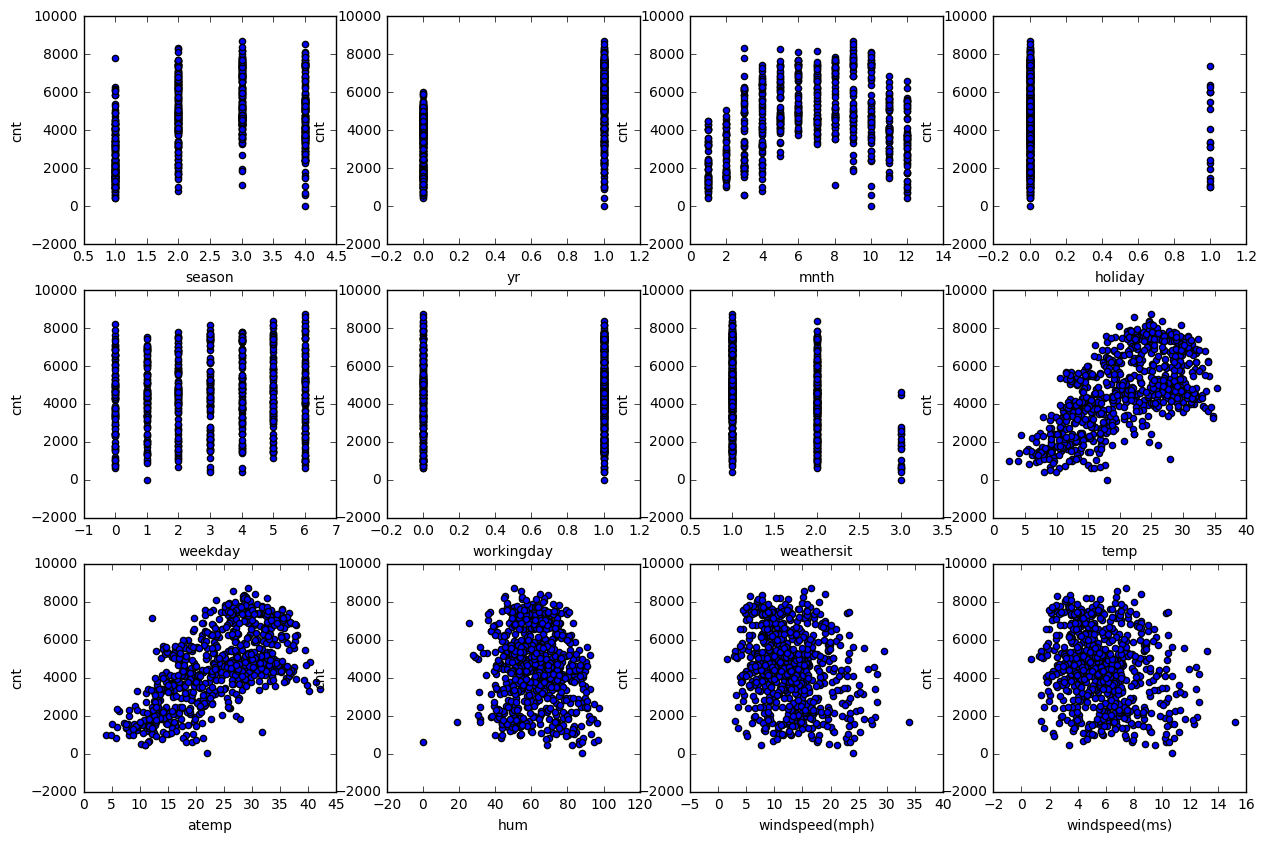

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: **квадратичный (парабола), ветвями вниз. При переходе через точку максимума (примерно 7 месяц = июль) при увеличении mnth -- cnt убывает.**
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: **temp и atemp. (А также year, holiday и workingday)**

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [5]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.loc[:,['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 
         'windspeed(mph)', 'windspeed(ms)']].corrwith(df['cnt'], axis=0)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [6]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr(method='pearson')

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [10]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean(axis=0)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [4]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [5]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]], with_mean=True, with_std=True)
y = df_shuffled["cnt"]

# Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [6]:
# Код 2.1 (1 балл)

# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

# Создайте объект линейного регрессора 
linear_regressor_bikes = linear_model.LinearRegression()

# обучите его на всех данных
linear_regressor_bikes.fit(X, y)

predictions_bikes = linear_regressor_bikes.predict(X)

# и выведите веса модели (OLS = Ordinary Least Squares method)
w_coefs_OLS = linear_regressor_bikes.coef_

[w for w in zip(df.columns[:12], w_coefs_OLS)]

[('season', 570.87078620113959),
 ('yr', 1021.9633439381753),
 ('mnth', -141.30382846485799),
 ('holiday', -86.758735093447129),
 ('weekday', 137.22457092867077),
 ('workingday', 56.390820388789052),
 ('weathersit', -330.22971383713093),
 ('temp', 367.48049583605359),
 ('atemp', 585.55019567298564),
 ('hum', -145.6112473842536),
 ('windspeed(mph)', 12459798114392.564),
 ('windspeed(ms)', -12459798114591.018)]

#### А еще распечатаем результаты реального кол-ва велосипедов (y) и предсказанного кол-ва (predictions_bikes) рядом, чтобы сравнить

In [ ]:
[item for item in zip(y, predictions_bikes)]

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

**Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.**

In [7]:
from sklearn.linear_model import Lasso, Ridge

## Lasso

In [8]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса 

lasso_regressor_bikes = linear_model.Lasso()
lasso_regressor_bikes.fit(X, y)
lasso_predictions = lasso_regressor_bikes.predict(X)

w_coefs_lasso = lasso_regressor_bikes.coef_

[w for w in zip(df.columns[:12], w_coefs_lasso)]

[('season', 560.24161603088658),
 ('yr', 1019.4634940657195),
 ('mnth', -128.73062703678738),
 ('holiday', -86.152781333711019),
 ('weekday', 137.34789390496292),
 ('workingday', 55.21237064135655),
 ('weathersit', -332.36985696234848),
 ('temp', 376.36323620969802),
 ('atemp', 576.53079350455175),
 ('hum', -144.12915500348635),
 ('windspeed(mph)', -197.1396894024854),
 ('windspeed(ms)', -2.8050371826175355e-08)]

## Ridge

In [9]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса

ridge_regressor_bikes = linear_model.Ridge()
ridge_regressor_bikes.fit(X, y)
ridge_predictions = ridge_regressor_bikes.predict(X)

w_coefs_ridge = ridge_regressor_bikes.coef_

[w for w in zip(df.columns[:12], w_coefs_ridge)]

[('season', 563.06457225201279),
 ('yr', 1018.9483787875281),
 ('mnth', -131.87332028247292),
 ('holiday', -86.746097997092832),
 ('weekday', 138.00511117871883),
 ('workingday', 55.903110375064465),
 ('weathersit', -332.34978849907259),
 ('temp', 386.4578891919719),
 ('atemp', 566.34704706000366),
 ('hum', -145.07132729867257),
 ('windspeed(mph)', -99.259441081762134),
 ('windspeed(ms)', -99.259441154372524)]

__Блок 2. Поясните,__ каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

__Ваш ответ (1 балл):__

**Коэффициент $\lambda$ позволяет "наказывать" модель за большие значения весов $w$, которые и являются симптомом переобучения (мультиколлинеарность тоже сюда входит).** 

Как он наказывает? 

**Так как мы минимизируем функционал, то соответственно минимизируем и норму весов. Когда минимизируем норму весов, то минимизируем сами веса по модулю.**

Возьмем норму $L_2$. По формуле для задачи оптимизации:
$$ \Large Q(w; X) + \lambda \|w\|^2 \rightarrow \min_{w} $$

Если $\lambda$ взять большим, то получим тенденцию к упрощению модели (занулению весов).

Также есть формула для нормы $L_1$:

$$ \Large Q(w; X) + \lambda \|w\|_1 \rightarrow \min_{w} $$


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [10]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),

for i, coef in enumerate(alphas):
    lasso_regressor_bikes = linear_model.Lasso(alpha=coef)
    lasso_regressor_bikes.fit(X, y)
    lasso_predictions = lasso_regressor_bikes.predict(X)
    w_coefs_lasso = lasso_regressor_bikes.coef_
    coefs_lasso[i] = w_coefs_lasso

print('\nКоэффициенты Lasso:\n')
print(coefs_lasso)

# а затем обучите Ridge и запишите веса в coefs_ridge.

for i, coef in enumerate(alphas):
    ridge_regressor_bikes = linear_model.Ridge(alpha=coef)
    ridge_regressor_bikes.fit(X, y)
    ridge_predictions = ridge_regressor_bikes.predict(X)
    w_coefs_ridge = ridge_regressor_bikes.coef_
    coefs_ridge[i] = w_coefs_ridge
    
print('\nКоэффициенты Ridge:\n')
print(coefs_ridge)


Коэффициенты Lasso:

[[  5.60241616e+02   1.01946349e+03  -1.28730627e+02  -8.61527813e+01
    1.37347894e+02   5.52123706e+01  -3.32369857e+02   3.76363236e+02
    5.76530794e+02  -1.44129155e+02  -1.97139689e+02  -2.80503718e-08]
 [  4.10969632e+02   9.77019409e+02  -0.00000000e+00  -5.34489688e+01
    9.19434374e+01   1.75372118e+01  -3.18125568e+02   3.22829934e+02
    6.10031512e+02  -9.10689615e+01  -1.45066095e+02  -2.29870394e-08]
 [  3.70077089e+02   9.35945490e+02   0.00000000e+00  -1.21619360e+01
    4.88886342e+01   0.00000000e+00  -3.08805664e+02   2.69417263e+02
    6.32502623e+02  -2.75042876e+01  -9.37749037e+01  -2.41651772e-08]
 [  3.32835717e+02   8.91870058e+02   0.00000000e+00  -0.00000000e+00
    0.00000000e+00   0.00000000e+00  -2.79616688e+02   2.11052030e+02
    6.62920880e+02  -0.00000000e+00  -5.01551472e+01  -2.62781113e-08]
 [  2.98134448e+02   8.45652857e+02   0.00000000e+00  -0.00000000e+00
    0.00000000e+00   0.00000000e+00  -2.35571345e+02   1.2414480

Визуализируем динамику весов при увеличении параметра регуляризации:

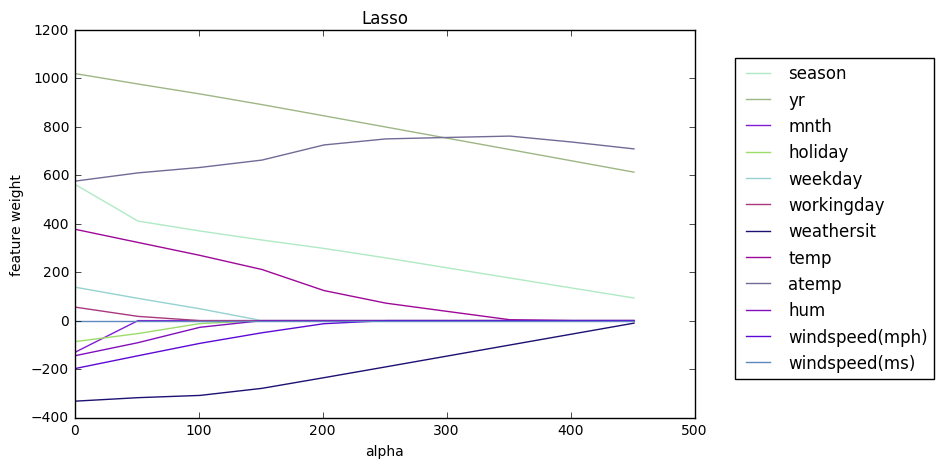

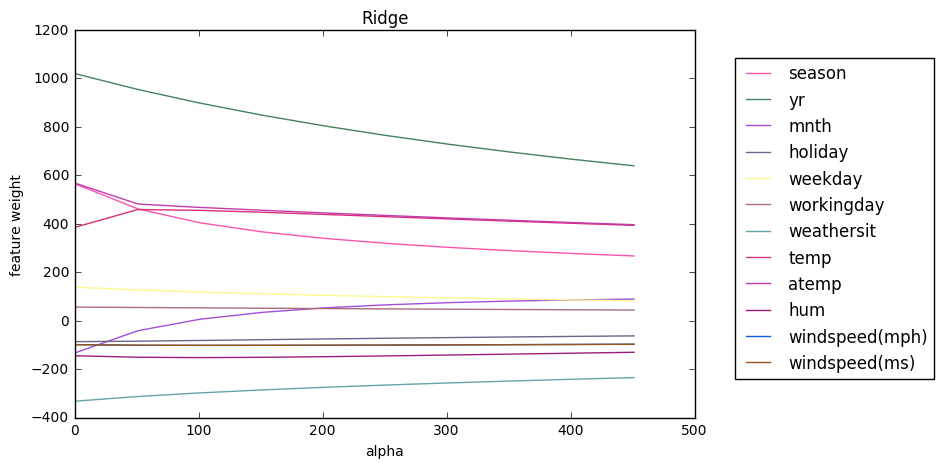

In [67]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 3. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: **Lasso агрессивнее уменьшает веса. На графиках Lasso: yr, season, temp, weekday, workingday резко уменьшаются. На графиках Ridge только yr, temp резко уменьшаются.**
    
    
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: **Все веса будут зануляться. При большом alpha получается логичнее занулить веса, так как мы минимизируем выражение.**
    
    
3. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: **Да, можно утверждать. Признак windspeed(ms) в Lasso константно равен 0 при любом значении alpha > 0.** 
    
    **А Ridge? Нет. У Ridge другая картина. Там ни при одном признаке не зануляются веса. Вес уменьшается при одном из дублирующих признаков. В частности перед признаком windspeed(ms) веса константно равны примерно -100.**


4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: **Подойдет Lasso, так как он зануляет веса перед неинформативными признаками.**

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [11]:
from sklearn.linear_model import LassoCV

In [12]:
alphas = np.arange(1, 100, 5)
alphas.shape

(20,)

In [13]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha

alphas = np.arange(1, 100, 5)
lasso = LassoCV(alphas=alphas, cv=3)
lasso_fitted = lasso.fit(X, y)
mse_matrix = lasso_fitted.mse_path_

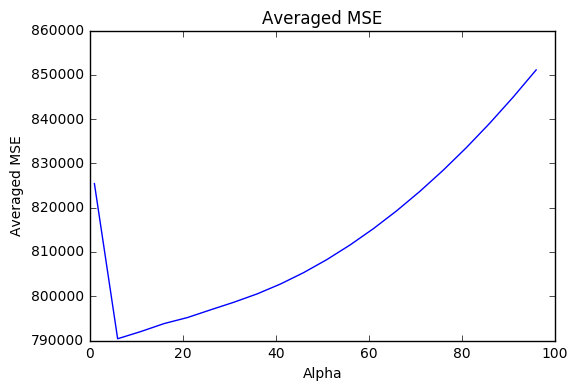

In [17]:
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 

# Усредним MSE по строкам
averaged_mse = np.mean(mse_matrix, axis=1)

plt.plot(lasso_fitted.alphas_, averaged_mse)
plt.xlabel('Alpha')
plt.ylabel('Averaged MSE')
plt.title('Averaged MSE')

In [18]:
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов

print('\nВыбранное alpha: {}\n'.format(lasso_fitted.alpha_))

for feature_name, coef in zip(df.columns, lasso_fitted.coef_):
    print('Признак {} и его коэффициент: {}'.format(feature_name, coef))


Выбранное alpha: 6

Признак season и его коэффициент: 532.0189828413539
Признак yr и его коэффициент: 1015.0602226430599
Признак mnth и его коэффициент: -100.03952614356658
Признак holiday и его коэффициент: -83.293959875299
Признак weekday и его коэффициент: 132.5044654909579
Признак workingday и его коэффициент: 51.55708561407386
Признак weathersit и его коэффициент: -330.5598567399813
Признак temp и его коэффициент: 370.6798550300367
Признак atemp и его коэффициент: 581.3969310654951
Признак hum и его коэффициент: -140.00740550068866
Признак windspeed(mph) и его коэффициент: -191.77140847135078
Признак windspeed(ms) и его коэффициент: -2.685459407120332e-08


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [25]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).

print('Min Alphas: {} {} {}'.format(lasso_fitted.alphas_[np.argmin(mse_matrix, axis=0)[0]], 
                                    lasso_fitted.alphas_[np.argmin(mse_matrix, axis=0)[1]], 
                                    lasso_fitted.alphas_[np.argmin(mse_matrix, axis=0)[2]]))

Min Alphas: 41 6 1


In [21]:
# рисует несколько scatter plot в таблице, имеющей размеры shape
def many_scatters(columns, titles, shape, alphas):
    plt.figure(figsize=(shape[1]*5, shape[0]*5))
    i = 1
    for column, title in zip (columns, titles):
        ax = plt.subplot(shape[0], shape[1], i)
        ax.set_title(title)
        i += 1
        plt.plot(alphas, column)

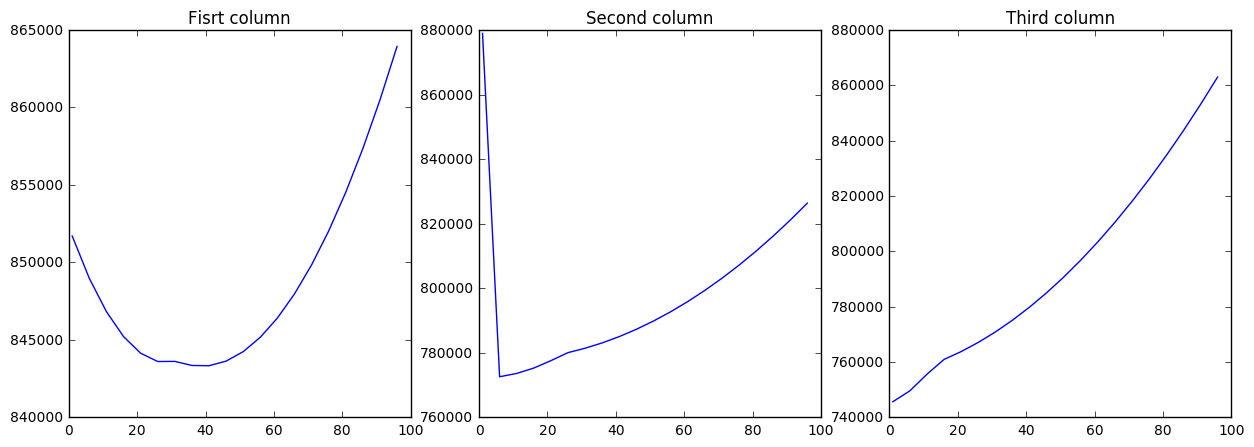

In [23]:
# На трех отдельных графиках визуализируйте столбцы .mse_path_

many_scatters([mse_matrix[:, 0], mse_matrix[:, 1], mse_matrix[:, 2]], 
              ['Fisrt column', 'Second column', 'Third column'], (1, 3), 
              lasso_fitted.alphas_)

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

/Users/macdrive/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


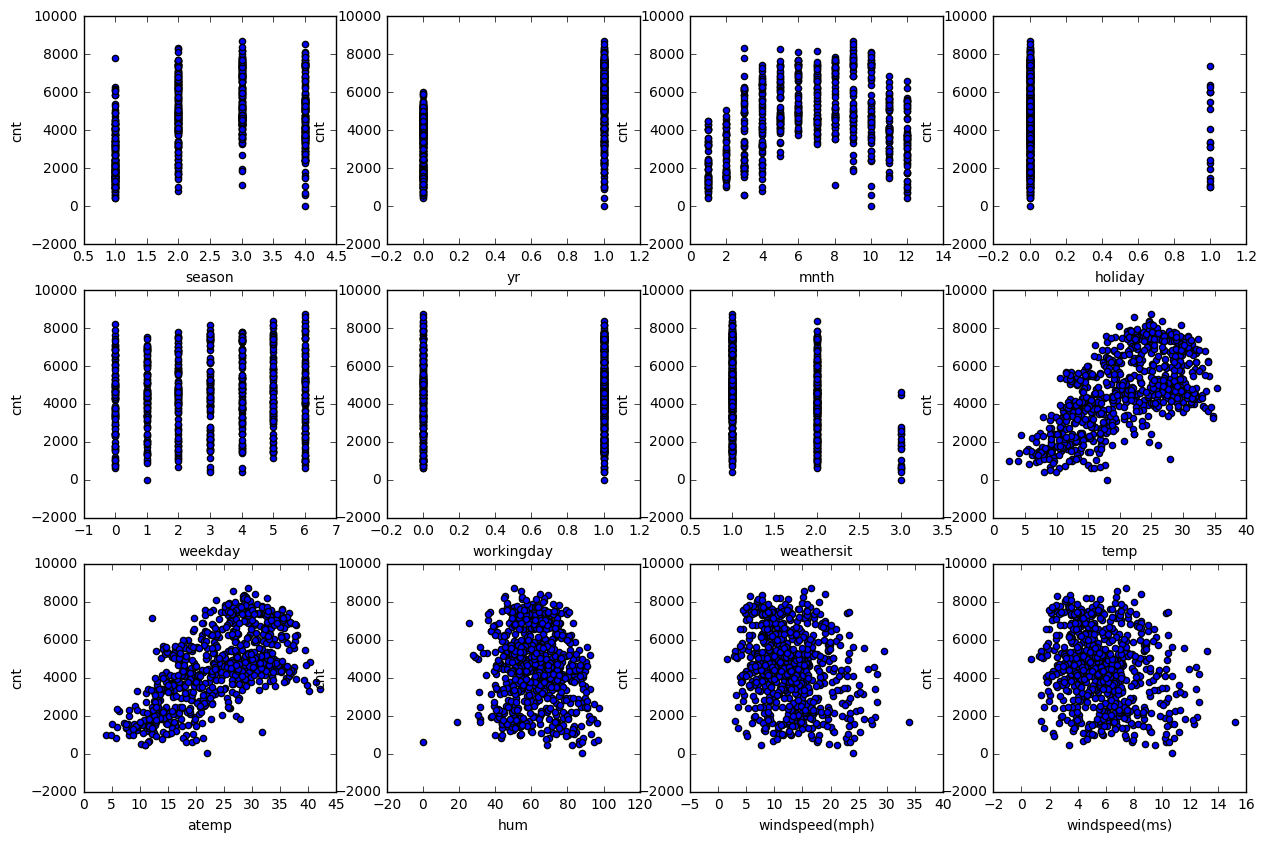

In [66]:
# выведем еще раз графики
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

In [67]:
# выведем еще раз пары признак-коэффициент

for feature_name, coef in zip(df.columns, lasso_fitted.coef_):
    print('Признак {} и его коэффициент: {}'.format(feature_name, coef))

Признак season и его коэффициент: 532.0189828413539
Признак yr и его коэффициент: 1015.0602226430599
Признак mnth и его коэффициент: -100.03952614356658
Признак holiday и его коэффициент: -83.293959875299
Признак weekday и его коэффициент: 132.5044654909579
Признак workingday и его коэффициент: 51.55708561407386
Признак weathersit и его коэффициент: -330.5598567399813
Признак temp и его коэффициент: 370.6798550300367
Признак atemp и его коэффициент: 581.3969310654951
Признак hum и его коэффициент: -140.00740550068866
Признак windspeed(mph) и его коэффициент: -191.77140847135078
Признак windspeed(ms) и его коэффициент: -2.685459407120332e-08


__Блок 4. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * **Ответ:**
    
       **Это признаки:**
    * season (вес 532)
    * yr (1015)
    * temp (370)
    * atemp (581)
    
**Для yr, temp и atemp видна линейная зависимость явно видна. Для season точно утверждать про линейную нельзя. Действительно, исходя из здравого смысла, чем больше значение, например, года yr, тем больше количество взятых велосипедов cnt.**

2. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

    * **Ответ**:
    
    **Это признаки:**

    * weathersit (-300)
    * hum (-140)
    * windspeed(mph) (-191)
    
**Убывающая линейная зависимость видна с трудом, но можно сказать, что она есть. Это значит, что чем больше признак, тем меньше значение cnt. Получается, чем хуже погода, тем меньше люди хотят брать велосипедов, а значит уменьшается cnt.**
   
   


    
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    
    * **Ответ**:
    
    **Это признак:**
    
    * windspeed(ms) (-2.685459407120332e-08)
    
**Модель его исключила, потому что он повторяет признак windspeed(mph),который уже учтен в модели с отрицательным коэффициентом.  Включение двух дублирующих друг друга признаков может привести к переобучению и большим весам.**

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.